# On-Chain Analysis of Smart Contract Dependency Risks on Ethereum

This notebook provides the visualizations for each RQ.

## RQ1: What is the scale of smart contract dependencies in the field?
Metrics:
- Created contracts (C)
- Destructed contracts (D)
- Alive contracts (A)
- Contracts per tansaction (I_t)
- Types of calls:
    + regular calls P_r
    + delegate calls P_d
    + static calls P_s 

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import seaborn as sns
import networkx as nx
from matplotlib.patches import Patch
import networkx as nx
import nxviz as nv
from nxviz import annotate
import numpy as np

Setting global plot parameters:

In [ ]:
plt.rcParams.update({
    'font.size': 16,  
    'axes.labelsize': 18, 
    'axes.labelweight': 'bold',
    'axes.titlesize': 20,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 16
})

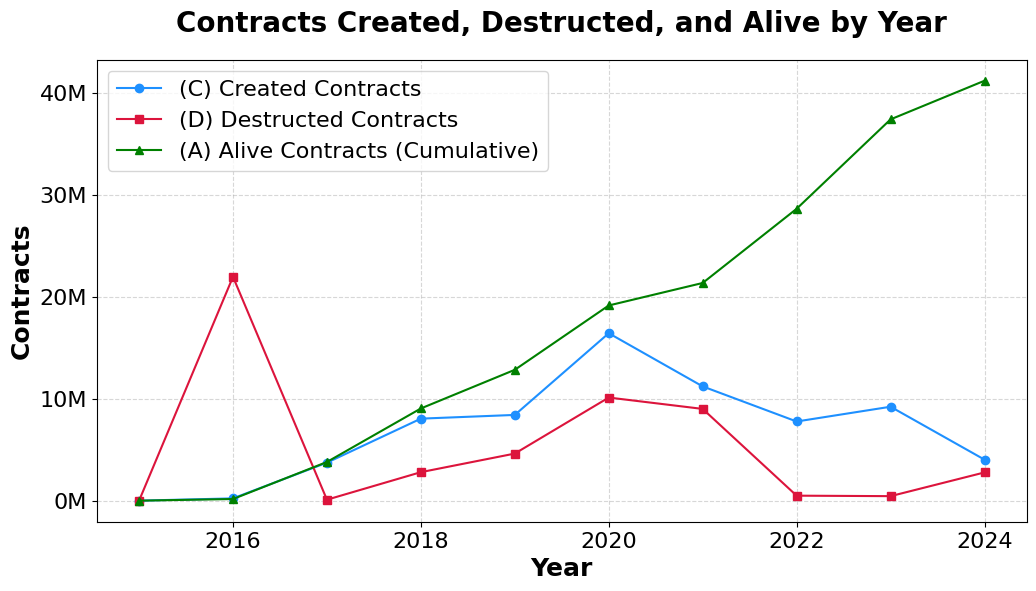

In [6]:
# Load data
create_df = pd.read_csv("../results/rq1/create_by_year.csv")
destruct_df = pd.read_csv("../results/rq1/destruct_by_year.csv")
alive_df = pd.read_csv("../results/rq1/alive_contracts_year.csv")

# Create the plot
plt.figure(figsize=(12, 6))  # Ensure same height


# Plot creation
plt.plot(create_df["year"], create_df["create_trace_count"], marker='o', linestyle='-', color='dodgerblue', label="(C) Created Contracts")

# Plot destruction
plt.plot(destruct_df["year"], destruct_df["destruct_trace_count"], marker='s', linestyle='-', color='crimson', label="(D) Destructed Contracts")

# Plot alive contracts
plt.plot(alive_df["year"], alive_df["n_alive_contracts"], marker='^', linestyle='-', color='green', label="(A) Alive Contracts (Cumulative)")

# Labels and title
plt.xlabel("Year", fontsize=18, fontweight='bold')
plt.ylabel("Contracts", fontsize=18, fontweight='bold')
plt.title("Contracts Created, Destructed, and Alive by Year", fontsize=20, pad=20, fontweight='bold')

# Format y-axis labels as 10M, 20M, etc.
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x/1_000_000)}M'))  # Convert to millions
ax.yaxis.set_major_locator(ticker.MultipleLocator(10_000_000))  # Set ticks at 10M intervals

# Add legend and grid
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
# plt.tight_layout()
# Save the plot
plt.savefig("../figures/rq1/created_destructed_alive.pdf", format='pdf', bbox_inches='tight')

# Show the plot
plt.show()

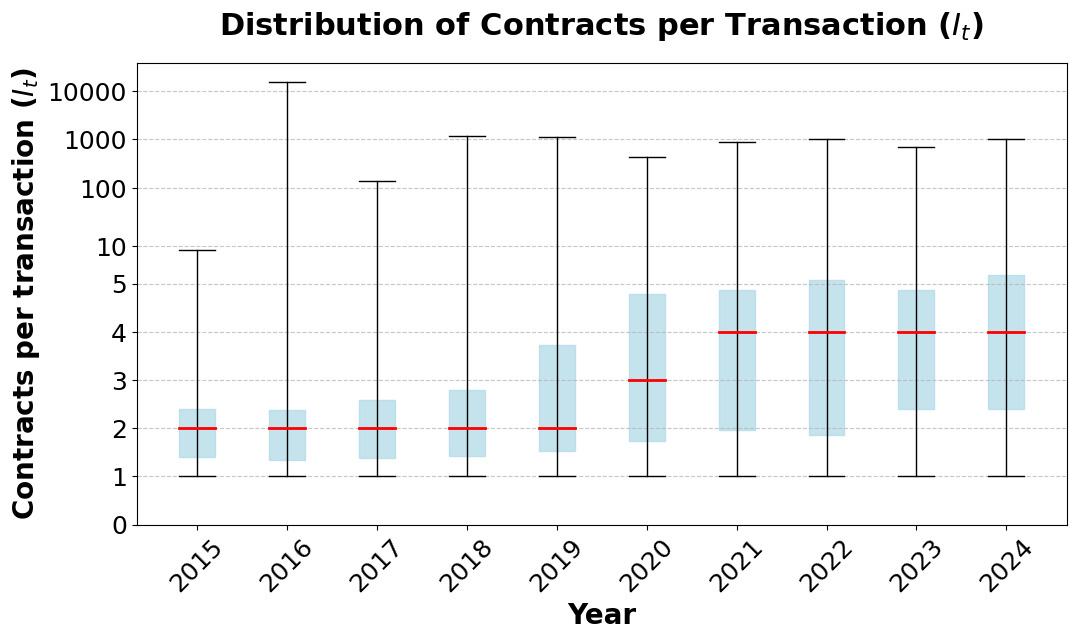

In [10]:

# Define the threshold for the hybrid scale
threshold = 5

# Function to transform the data
def hybrid_scale(y):
    """
    Apply a hybrid scale: linear below the threshold, logarithmic above.
    """
    # Ensure y is a numpy array
    y = np.asarray(y)
    # Apply linear scale for y <= threshold
    linear_part = np.where(y <= threshold, y, 0)
    # Apply logarithmic scale for y > threshold
    log_part = np.where(y > threshold, threshold + np.log10(np.maximum(y - threshold + 1, 1)), 0)
    # Combine the two parts
    return linear_part + log_part

# Function to reverse the transformation (for axis labels)
def hybrid_scale_inverse(y_transformed):
    """
    Reverse the hybrid scale transformation.
    """
    # Ensure y_transformed is a numpy array
    y_transformed = np.asarray(y_transformed)
    # Reverse linear scale for y_transformed <= threshold
    linear_part = np.where(y_transformed <= threshold, y_transformed, 0)
    # Reverse logarithmic scale for y_transformed > threshold
    log_part = np.where(y_transformed > threshold, 10**(y_transformed - threshold) + threshold - 1, 0)
    # Combine the two parts
    return linear_part + log_part

# Load and prepare data
years = range(2015, 2024 + 1)
dfs = []
for year in years:
    dfi = pd.read_csv(f"../results/rq1/contracts_per_tx_{year}.csv")
    dfi["year"] = year
    dfs.append(dfi)

df = pd.concat(dfs)


# Function to calculate weighted percentiles
def weighted_percentile(data, weights, percentiles):
    """
    Calculate weighted percentiles.
    :param data: Array of values.
    :param weights: Array of weights (frequencies).
    :param percentiles: List of percentiles (e.g., [25, 50, 75]).
    :return: Array of percentile values.
    """
    sorted_indices = np.argsort(data)
    sorted_data = data[sorted_indices]
    sorted_weights = weights[sorted_indices]
    cum_weights = np.cumsum(sorted_weights)
    total_weight = cum_weights[-1]
    percentile_positions = total_weight * np.array(percentiles) / 100
    percentiles_values = np.interp(percentile_positions, cum_weights, sorted_data)
    return percentiles_values

# Calculate boxplot statistics for each year
boxplot_stats = []
for year in years:
    df_year = df[df['year'] == year]
    addresses_called = df_year['addresses_called'].values
    frequencies = df_year['frequency'].values
    
    # Calculate weighted percentiles
    min_val = np.min(addresses_called)
    max_val = np.max(addresses_called)
    q1, median, q3 = weighted_percentile(addresses_called, frequencies, [25, 50, 75])
    
    # Store statistics
    boxplot_stats.append({
        'year': year,
        'min': min_val,
        'q1': q1,
        'median': int(np.round(median)),
        'q3': q3,
        'max': max_val
    })

# Convert to DataFrame
boxplot_df = pd.DataFrame(boxplot_stats)

# Create boxplot manually
plt.figure(figsize=(12, 6))  # Ensure same height
for i, row in boxplot_df.iterrows():
    year = row['year']
    # Transform the data using the hybrid scale
    min_transformed = hybrid_scale(row['min'])
    q1_transformed = hybrid_scale(row['q1'])
    median_transformed = hybrid_scale(row['median'])
    q3_transformed = hybrid_scale(row['q3'])
    max_transformed = hybrid_scale(row['max'])
    
    # Plot the transformed data
    plt.plot([year, year], [min_transformed, max_transformed], color='black', linewidth=1)  # Whiskers
    plt.plot([year - 0.2, year + 0.2], [min_transformed, min_transformed], color='black', linewidth=1)  # Lower whisker cap
    plt.plot([year - 0.2, year + 0.2], [max_transformed, max_transformed], color='black', linewidth=1)  # Upper whisker cap
    plt.fill_between([year - 0.2, year + 0.2], [q1_transformed, q1_transformed], [q3_transformed, q3_transformed], color='lightblue', alpha=0.7)  # Box
    plt.plot([year - 0.2, year + 0.2], [median_transformed, median_transformed], color='red', linewidth=2)  # Median line

# Customize y-axis labels
y_ticks = [0, 1, 2, 3, 4, 5, 10, 100, 1000, 10000]  # Original values
y_tick_labels = [str(x) for x in y_ticks]  # Labels for the original values
y_ticks_transformed = hybrid_scale(np.array(y_ticks))  # Transform the ticks

plt.yticks(y_ticks_transformed, labels=y_tick_labels, fontsize=18)  # Set custom ticks and labels (bold)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid lines

# Add titles and labels
plt.title("Distribution of Contracts per Transaction ($I_t$)", fontsize=22, pad=20, weight='bold')
plt.xlabel("Year", fontsize=20, weight='bold')
plt.ylabel("Contracts per transaction ($I_t$)", fontsize=20, weight='bold')
plt.xticks(years, rotation=45, fontsize=18)


# plt.tight_layout()

# Save and display the plot
plt.savefig("../figures/rq1/contracts_per_tx_year.pdf", format='pdf', bbox_inches='tight')
plt.show()

## RQ2: Which are the most prolific creators of smart contracts?
Metrics:
- Contracts created by EOA
- Contracts created by Contracts

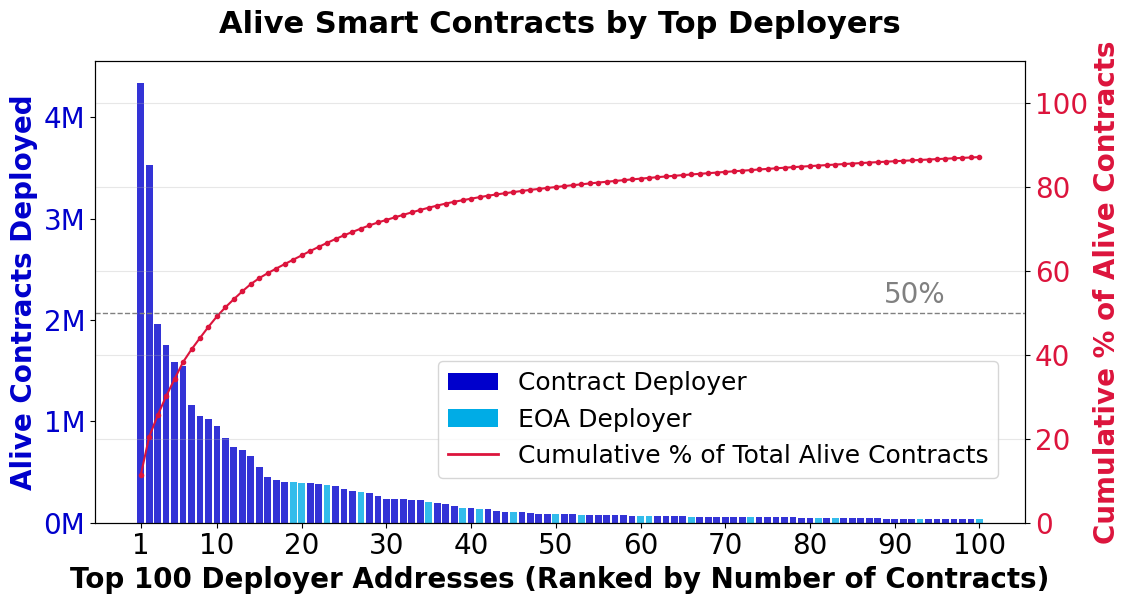

In [16]:

# Load the data
df = pd.read_csv("../results/rq2/top_deployers_alive.csv")
eoa_df = pd.read_csv("../results/rq2/top_eoa_deployers_filtered.csv")

# Sort the data
df = df.sort_values(by="deployed_alive_contracts", ascending=False)

# Compute cumulative sum and proportion
total_alive_contracts = df["deployed_alive_contracts"].sum()
df["cumulative_sum"] = df["deployed_alive_contracts"].cumsum()
df["cumulative_proportion"] = df["cumulative_sum"] / total_alive_contracts * 100

# Limit to top 51 addresses
df = df.iloc[:100].reset_index(drop=True)

# Set bar colors: light blue for EOAs, dark blue for others
eoa_addresses = set(eoa_df["address"])
df["color"] = df["address"].apply(lambda x: '#00ace6' if x in eoa_addresses else '#0000cc')  # Light blue vs default blue

# Plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar chart
bars = ax1.bar(df.index, df["deployed_alive_contracts"], color=df["color"], alpha=0.8, label='Alive Contracts Deployed')
ax1.set_xlabel("Top 100 Deployer Addresses (Ranked by Number of Contracts)", fontsize=20)
# Define the custom x-ticks you want to show
xticks_to_show = [0] + [i for i in range(9, len(df), 10)]  # 0-indexed, so 0 (for 1), 9 (for 10), 19 (for 20), etc.
xtick_labels = [i + 1 for i in xticks_to_show]             # Convert to 1-based labels

# Apply the custom ticks
ax1.set_xticks(xticks_to_show)
ax1.set_xticklabels(xtick_labels)
ax1.set_ylabel("Alive Contracts Deployed", color='#0000cc', fontsize=20)
ax1.tick_params(axis='y', labelcolor='#0000cc')
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x/1e6:.0f}M'))

# Line chart
ax2 = ax1.twinx()
ax2.plot(df.index, df["cumulative_proportion"], marker='.', linestyle='-', color='crimson', label='Cumulative % of Total Alive Contracts')
ax2.set_ylabel("Cumulative % of Alive Contracts", color='crimson', fontsize=20)
ax2.tick_params(axis='y', labelcolor='crimson')
ax2.set_ylim(0, 110)
ax2.axhline(50, color='gray', linestyle='--', linewidth=1)
ax2.text(len(df)*0.95, 51, '50%', color='gray', ha='right', va='bottom', fontsize=20)

# Title and grid
plt.title("Alive Smart Contracts by Top Deployers", fontsize=22, fontweight='bold', pad=20)
plt.grid(alpha=0.3)

# Legend

legend_elements = [
    Patch(facecolor='#0000cc', label='Contract Deployer'),
    Patch(facecolor='#00ace6', label='EOA Deployer'),
    plt.Line2D([0], [0], color='crimson', lw=2, label='Cumulative % of Total Alive Contracts')
]
fig.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0.4, 0.4), fontsize=18)

plt.rcParams.update({
    'font.size': 20,  # General font size
    'axes.labelsize': 20,  # Bigger axis labels
    'axes.labelweight': 'bold',
    'axes.titlesize': 20,  # Bigger title
    'xtick.labelsize': 20,  # Bigger tick labels
    'ytick.labelsize': 20,
    'legend.fontsize': 20  # Bigger legend
})

# plt.tight_layout()
plt.savefig("../figures/rq2/top_100_deployers.pdf", format='pdf', bbox_inches='tight')
plt.show()


## RQ4: How transparent are smart contract calls inter-actions in major DeFi protocols?
Study cases:
- Uniswap
- Lido

### Uniswap Study Case

In [27]:
plt.rcParams.update({
    'font.size': 16,  # General font size
    'axes.labelsize': 16,  # Bigger axis labels
    'axes.labelweight': 'bold',
    'axes.titlesize': 16,  # Bigger title
    'xtick.labelsize': 16,  # Bigger tick labels
    'ytick.labelsize': 16,
    'legend.fontsize': 16  # Bigger legend
})

Number of all nodes: 69
Number of nodes in each color group:
Color group 0: 21 nodes
Color group 1: 31 nodes
Color group 2: 17 nodes
Number of unverified nodes in each color group:
Color group 0: 3 unverified nodes
Color group 1: 0 unverified nodes
Color group 2: 0 unverified nodes


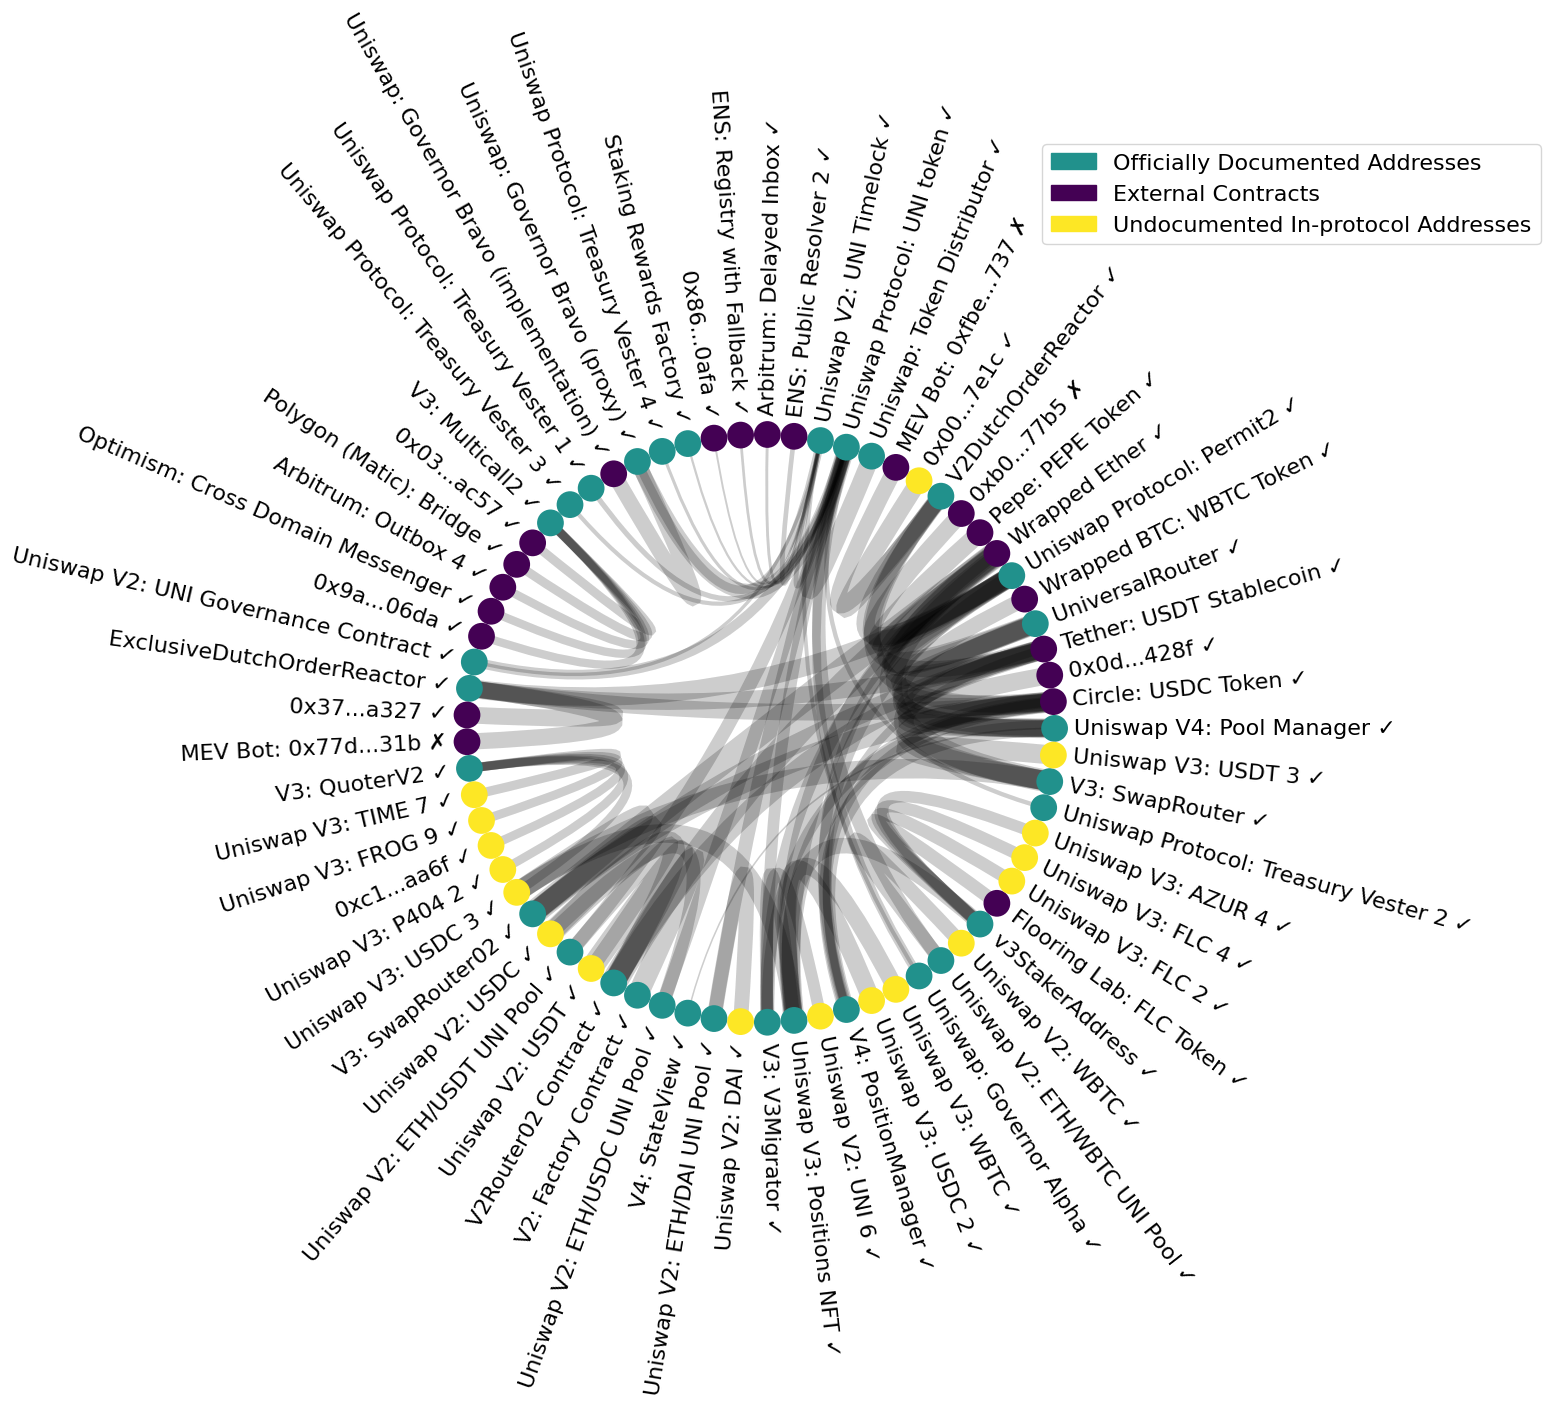

In [28]:
from utils import get_etherscan_label, get_etherscan_verification

official_labels_file_path = "../results/rq4/uniswap_all.csv"
contracts_file_path = "../results/rq4/uniswap_top_5_to_addr.csv"
creators_file_path = "../results/rq4/uniswap_top_10_to_creators.csv"


def load_data(contracts_file, labels_file, creators_file):
    """Load contracts and address labels data from CSV files."""
    data = pd.read_csv(contracts_file)
    address_labels = pd.read_csv(labels_file)
    creators = pd.read_csv(creators_file)
    created = creators["to_address"].unique()
    to_addresses = data["to_address"].unique()

    addresses_w_label = address_labels["address"].unique()
    addresses_wo_label = [address for address in to_addresses if address not in addresses_w_label]

    # get the labels for the addresses that are not in the labels
    for addr in addresses_wo_label:
        label = get_etherscan_label(addr)
        verified = get_etherscan_verification(addr)
        address_labels.loc[len(address_labels)] = [addr, False, label, verified]
    # update labels file
    address_labels.to_csv(labels_file, index=False)
    # Create a dictionary for quick label lookup (keys in lowercase)
    address_group_dict = {
        k.lower(): bool(v) for k, v in zip(address_labels["address"], address_labels["uniswap"])
    }
    address_label_dict = {
        k.lower(): v for k, v in zip(address_labels["address"], address_labels["label"]) if pd.notna(v)
    }
    verified_dict = {
        k.lower(): bool(v) for k, v in zip(address_labels["address"], address_labels["verified"]) if pd.notna(v)
    }
    return data, address_label_dict, address_group_dict, verified_dict, created


def build_graph(data):
    """Create a graph from the contract interactions data."""
    G = nx.Graph()
    for _, row in data.iterrows():
        G.add_edge(
            row["from_address"].lower(),
            row["to_address"].lower(),
            weight=row["call_count"],
        )
    return G


def remove_invalid_nodes(G):
    """Remove nodes with addresses starting with the invalid pattern."""
    invalid_nodes = [
        node
        for node in G.nodes()
        if str(node).startswith("0x000000000000000000000000000000000000000")
    ]
    G.remove_nodes_from(invalid_nodes)
    return G


def relabel_nodes_with_labels(G, address_label_dict, verified_dict):
    """
    Relabel nodes using the provided address labels dictionary.
    Then, shorten long hexadecimal addresses and append the verification tick.
    """
    for node in G.nodes():
        is_verified = verified_dict.get(node, False)
        G.nodes[node]["verified"] = "✓" if is_verified else "✗"
    G = nx.relabel_nodes(G, address_label_dict)
    G = nx.relabel_nodes(
        G, lambda x: x[:4] + "..." + x[-4:] if str(x).startswith("0x") else x
    )
    G = nx.relabel_nodes(G, lambda x: x + " " + str(G.nodes[x]["verified"]))
    return G


def apply_edge_transformations(G):
    """Apply logarithmic transformation to the edge weights."""
    for u, v, d in G.edges(data=True):
        d["log_weight"] = np.log1p(d["weight"])
    return G


def assign_color_groups(G, address_group_dict, created):
    """
    Assign a color group to each node based on whether it is an address.
    Nodes that start with '0x' are group 0; all others are group 1.
    """
    for node in G.nodes():
        if address_group_dict.get(str(node)) == True:
            G.nodes[node]["color_group"] = 1
        elif str(node) in created:
            G.nodes[node]["color_group"] = 2
        else:
            G.nodes[node]["color_group"] = 0
    return G


def generate_plot(G):
    """Generate a circos plot of the network using nxviz and save the output."""
    plt.figure(figsize=(15, 15))
    nv.circos(G, node_color_by="color_group", edge_lw_by="log_weight")
    annotate.circos_labels(G, layout="rotate")
    labels = ["Officially Documented Addresses",
               "External Contracts",
               "Undocumented In-protocol Addresses"
               ]
        
    legends = {"loc": "lower left", "borderaxespad": 0.5, "title_fontsize": 12, "labels": labels, "bbox_to_anchor": (0.9, 1.2)
    }
    annotate.node_colormapping(G, "color_group", legend_kwargs=legends)
    plt.tight_layout()
    plt.savefig("../figures/rq4/uniswap_network.pdf", format='pdf', bbox_inches='tight')
    plt.show()


def print_node_statistics(G):       
    """Print the number of nodes and their distribution by color group."""
    print(f"Number of all nodes: {len(G.nodes())}")
    color_group_counts = {0: 0, 1: 0, 2: 0}
    unverified_count = {0: 0, 1: 0, 2: 0}
    for node in G.nodes():
        color_group = G.nodes[node]["color_group"]
        color_group_counts[color_group] += 1
        if G.nodes[node]["verified"] == "✗":
            unverified_count[color_group] += 1
    print("Number of nodes in each color group:")
    for group, count in color_group_counts.items():
        print(f"Color group {group}: {count} nodes")
    print("Number of unverified nodes in each color group:")
    for group, count in unverified_count.items():
        print(f"Color group {group}: {count} unverified nodes")


# Load data and build initial graph
data, address_label_dict, address_group_dict, verified_dict, created = load_data(contracts_file_path, official_labels_file_path, creators_file_path)
G = build_graph(data)
G = remove_invalid_nodes(G)



# Apply transformations to edge weights and assign color groups to nodes
G = apply_edge_transformations(G)
G = assign_color_groups(G, address_group_dict, created)
# Relabel nodes with official labels and verification ticks
G = relabel_nodes_with_labels(G, address_label_dict, verified_dict)

# Print some statistics about the graph
print_node_statistics(G)

# Generate and save the network plot
generate_plot(G)

# save the graph as pdf


Contract 0xb8ffc3cd6e7cf5a098a1c92f48009765b24088dc is verified.
Contract 0x2b33cf282f867a7ff693a66e11b0fcc5552e4425 is verified.
Contract 0xae7ab96520de3a18e5e111b5eaab095312d7fe84 is verified.
Contract 0x17144556fd3424edc8fc8a4c940b2d04936d17eb is verified.
Contract 0xfddf38947afb03c621c71b06c9c70bce73f12999 is verified.
Contract 0xf73a1260d222f447210581ddf212d915c09a3249 is verified.
Contract 0x5a98fcbea516cf06857215779fd812ca3bef1b32 is verified.
Contract 0x7f39c581f595b53c5cb19bd0b3f8da6c935e2ca0 is verified.
Contract 0xde3a93028f2283cc28756b3674bd657eafb992f4 is verified.
Contract 0x00000000219ab540356cbb839cbe05303d7705fa is verified.
Contract 0x8f73e4c2a6d852bb4ab2a45e6a9cf5715b3228b7 is verified.
Contract 0xd8784e748f59ba711fb5643191ec3fadd50fb6df is verified.
Contract 0xc1d0b3de6792bf6b4b37eccdcc24e45978cfd2eb is verified.
Contract 0x55032650b14df07b85bf18a3a3ec8e0af2e028d5 is verified.
Contract 0x47ebab13b806773ec2a2d16873e2df770d130b50 is verified.
Contract 0x889edc2edab5f4

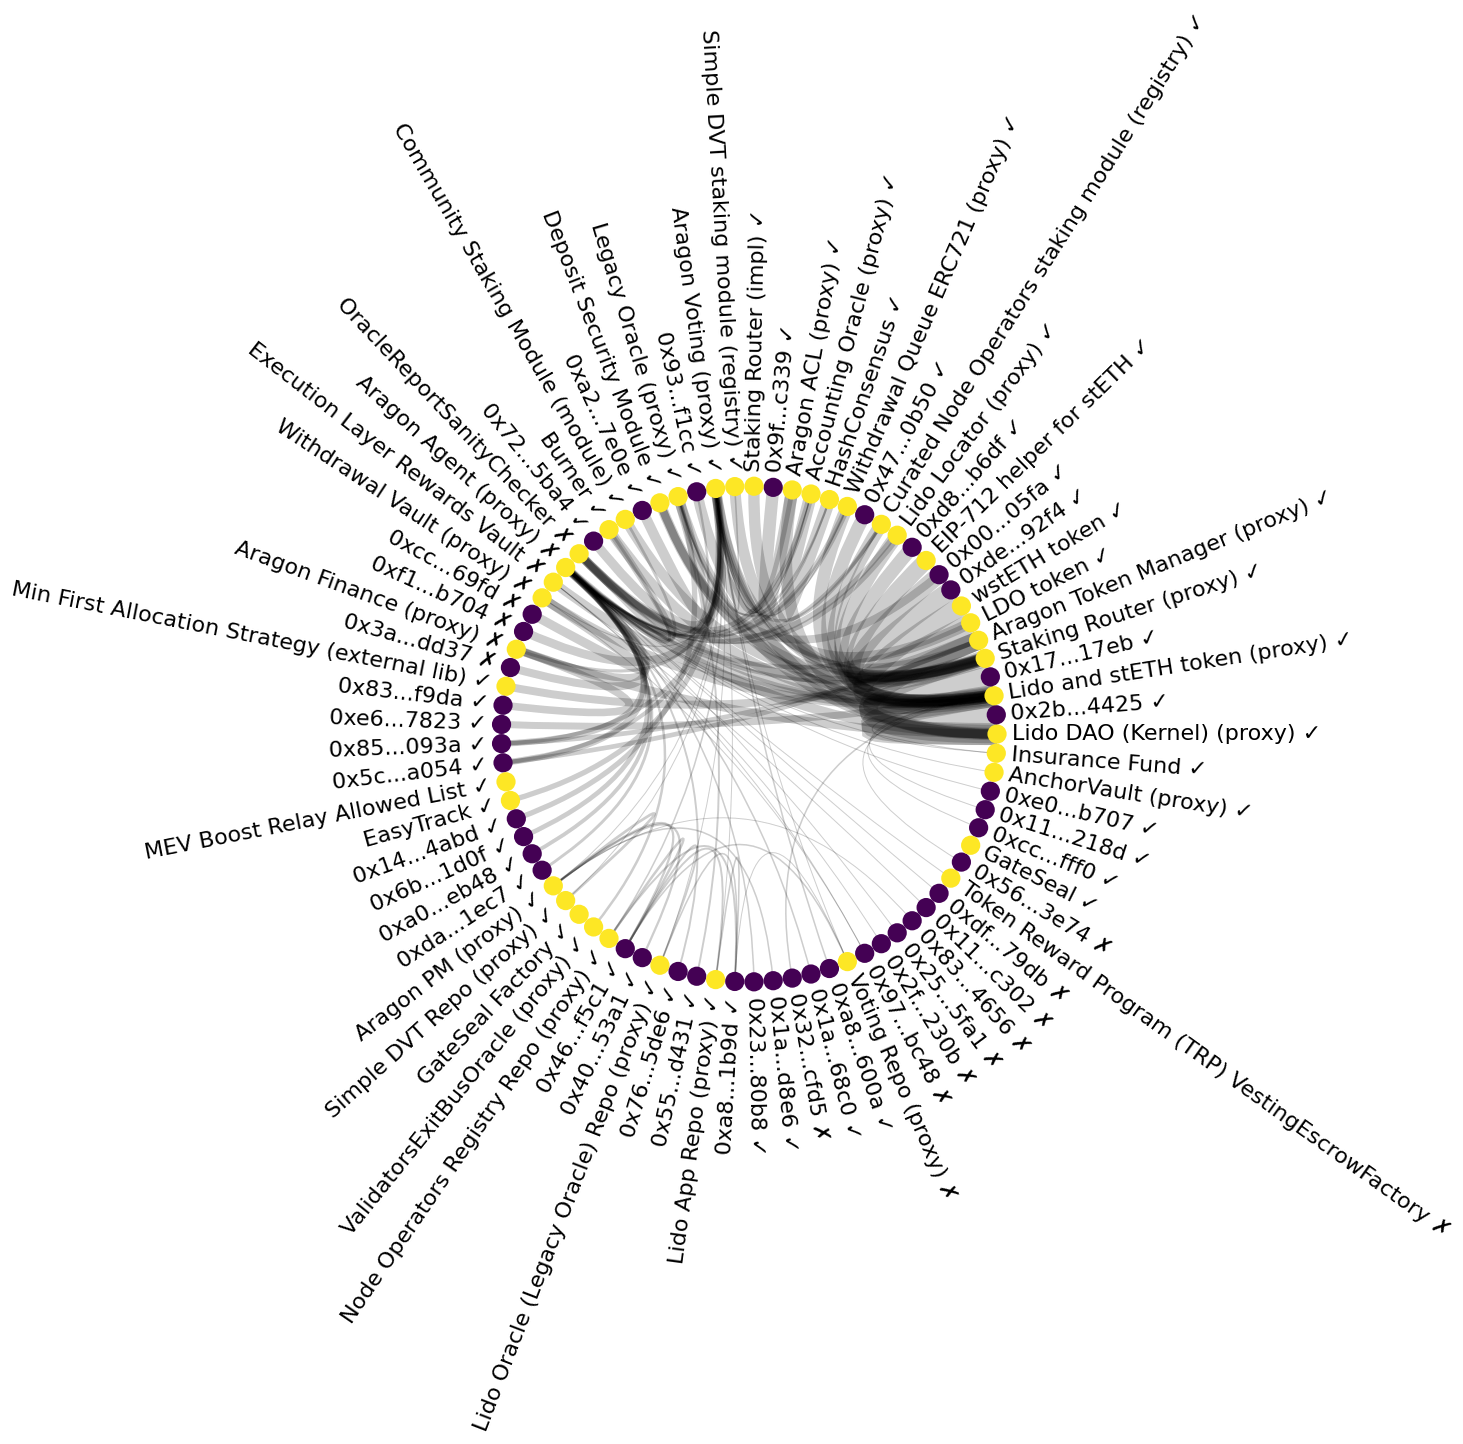

In [ ]:
contracts_file_path = "../results/rq4/lido_to_addr.csv"
official_labels_file_path = "../results/rq4/lido_labels.csv"



def load_data(contracts_file, labels_file):
    """Load contracts and address labels data from CSV files."""
    data = pd.read_csv(contracts_file)
    address_labels = pd.read_csv(labels_file)
    # Create a dictionary for quick label lookup (keys in lowercase)
    address_label_dict = {
        k.lower(): v for k, v in zip(address_labels["address"], address_labels["label"])
    }
    return data, address_label_dict


def build_graph(data):
    """Create a graph from the contract interactions data."""
    G = nx.Graph()
    for _, row in data.iterrows():
        G.add_edge(
            row["from_address"].lower(),
            row["to_address"].lower(),
            weight=row["call_count"],
        )
    return G


def remove_invalid_nodes(G):
    """Remove nodes with addresses starting with the invalid pattern."""
    invalid_nodes = [
        node
        for node in G.nodes()
        if str(node).startswith("0x000000000000000000000000000000000000000")
    ]
    G.remove_nodes_from(invalid_nodes)
    return G


def update_verification_status(G):
    """
    Update each node in the graph with its verification status.
    Verified nodes get a tick ("✓") while non-verified ones get a cross ("✗").
    """
    for node in G.nodes():
        is_verified = get_etherscan_verification(node)
        print(f"Contract {node} is {'verified' if is_verified else 'not verified'}.")
        G.nodes[node]["verified"] = "✓" if is_verified else "✗"
    return G


def relabel_nodes_with_labels(G, address_label_dict):
    """
    Relabel nodes using the provided address labels dictionary.
    Then, shorten long hexadecimal addresses and append the verification tick.
    """
    # Replace addresses with official labels if available
    G = nx.relabel_nodes(G, address_label_dict)
    # For any node that is still an address, shorten it (e.g., 0x1234...abcd)
    G = nx.relabel_nodes(
        G, lambda x: x[:4] + "..." + x[-4:] if str(x).startswith("0x") else x
    )
    # Append verification status to each node label
    G = nx.relabel_nodes(G, lambda x: x + " " + str(G.nodes[x]["verified"]))
    return G


def apply_edge_transformations(G):
    """Apply logarithmic transformation to the edge weights."""
    for u, v, d in G.edges(data=True):
        d["log_weight"] = np.log1p(d["weight"])
    return G


def assign_color_groups(G):
    """
    Assign a color group to each node based on whether it is an address.
    Nodes that start with '0x' are group 0; all others are group 1.
    """
    for node in G.nodes():
        if str(node).startswith("0x"):
            G.nodes[node]["color_group"] = 0
        else:
            G.nodes[node]["color_group"] = 1
    return G


def generate_plot(G, output_file):
    """Generate a circos plot of the network using nxviz and save the output."""
    plt.figure(figsize=(14, 14))
    nv.circos(G, node_color_by="color_group", edge_lw_by="log_weight")
    annotate.circos_labels(G, layout="rotate")
    plt.tight_layout()
    plt.savefig(output_file)
    print(f"Saved network diagram to {output_file}")


def print_node_statistics(G):
    """Print the number of nodes and their distribution by color group."""
    print(f"Number of all nodes: {len(G.nodes())}")
    color_group_counts = {0: 0, 1: 0}
    for node in G.nodes():
        color_group = G.nodes[node]["color_group"]
        color_group_counts[color_group] += 1
    print("Number of nodes in each color group:")
    for group, count in color_group_counts.items():
        print(f"Color group {group}: {count} nodes")


# def main():
# Load data and build initial graph
data, address_label_dict = load_data(contracts_file_path, official_labels_file_path)
G = build_graph(data)
G = remove_invalid_nodes(G)

# Update nodes with verification status from Etherscan
G = update_verification_status(G)

# Relabel nodes with official labels and verification ticks
G = relabel_nodes_with_labels(G, address_label_dict)

# Apply transformations to edge weights and assign color groups to nodes
G = apply_edge_transformations(G)
G = assign_color_groups(G)

# Print some statistics about the graph
print_node_statistics(G)

# Generate and save the network plot
output_file = "../figures/rq4/lido_network.pdf"
generate_plot(G, output_file)

